In [92]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [98]:
# load the regional / industry data
file_path = 'regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx'

df = pd.read_excel(file_path, sheet_name='Table 1c', header=1)

# Make sure "Region name" exists and extract the unique value of this column
if 'Region name' in df.columns:
    unique_regions = df['Region name'].dropna().unique()
    print("Region name:")
    for region in unique_regions:
        print(region)
else:
    print("The 'Region name' not found")


Region name:
United Kingdom
England
North East
North West
Yorkshire and The Humber
East Midlands
West Midlands
East
London
South East
South West
Wales
Scotland
Northern Ireland
Extra-Regio
United Kingdom less Extra-Regio


In [94]:
# target regions and industries
target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]
target_industries = [
  'Motion picture, video and TV programme production',
  'Financial and insurance activities',
  'Manufacture of beverages and tobacco products',
  'Manufacture of basic and fabricated metal products',
  'Financial service activities',
  'Public administration and defence',
]

# filter the data based on target regions and industries
df_filtered = df[
    (df["Region name"].isin(target_regions)) &
    (df["SIC07 description"].isin(target_industries))
]

# Extract the required column: Region name year column
year_cols = [str(year) for year in range(2016, 2024)]
cols_to_keep = ["Region name"] + year_cols
df_final = df_filtered[cols_to_keep].copy()

# De-duplication (to prevent duplicate lines
df_grouped = df_final.groupby("Region name")[year_cols].sum().reset_index()

print(df_grouped)


                Region name    2016    2017    2018    2019    2020    2021  \
0                      East   18743   19972   20128   20639   19979   20610   
1             East Midlands   12476   12563   12885   13403   13731   14941   
2                    London  145487  155196  154998  154439  157297  167276   
3                North East    8868    9078    9281    9305    8973    9427   
4                North West   27248   28731   28722   29052   29074   32756   
5                South East   33648   36395   36121   36229   37975   40981   
6                South West   23985   24605   24785   24846   24564   25641   
7             West Midlands   21590   21467   21941   22361   22339   23372   
8  Yorkshire and The Humber   21572   22779   22618   22516   23078   24503   

     2022    2023  
0   22097   24173  
1   16321   17149  
2  182634  200028  
3   10395   11935  
4   36587   36919  
5   42823   47114  
6   28818   31397  
7   26829   29025  
8   27289   29669  


In [100]:
# load the pollution data
data_dir = "Dataset_v4"

# pnec value
target_substances = {
    "Copper": 1.0,
}

# Used for storing all annual data
all_years_data = []

# Traverse from 2016 to 2023
for year in range(2016, 2024):
    file_name = f"d{str(year)[-2:]}_v4.csv"
    file_path = os.path.join(data_dir, file_name)

    try:
        df = pd.read_csv(file_path)
        df_filtered = df[df["SUBSTANCE NAME"].isin(target_substances.keys())].copy()
        df_filtered["Year"] = year
        df_filtered["PNEC"] = df_filtered["SUBSTANCE NAME"].map(target_substances)
        df_filtered["Pollution Score"] = df_filtered["QUANTITY RELEASED (kg)"] / df_filtered["PNEC"]

        # Summarize by REGION and SUBSTANCE
        df_grouped = (
            df_filtered.groupby(["Year", "REGION", "SUBSTANCE NAME"])
            .agg({"QUANTITY RELEASED (kg)": "sum", "Pollution Score": "sum"})
            .reset_index()
        )

        all_years_data.append(df_grouped)

    except FileNotFoundError:
        print(f"{file_path} not found")

# merge all years' data
final_df = pd.concat(all_years_data, ignore_index=True)

# Add to the pollution severity ranking
final_df["Rank"] = final_df.groupby(["Year", "SUBSTANCE NAME"])["Pollution Score"]\
                           .rank(method="dense", ascending=False)

# export as csv
final_df.to_csv("pollution_severity_ranked_by_region.csv", index=False)

# output few lines 
print(final_df.head(20))


    Year                    REGION SUBSTANCE NAME  QUANTITY RELEASED (kg)  \
0   2016             East Midlands         Copper              3550.48000   
1   2016           East of England         Copper              5500.00000   
2   2016                    London         Copper             16878.71600   
3   2016                North East         Copper              3170.72800   
4   2016                North West         Copper              5212.67180   
5   2016                South East         Copper              7261.41012   
6   2016                South West         Copper              2474.44000   
7   2016             West Midlands         Copper              7620.40000   
8   2016  Yorkshire and The Humber         Copper              3791.20514   
9   2017             East Midlands         Copper              3812.11000   
10  2017           East of England         Copper              3538.10000   
11  2017                    London         Copper             14825.72800   

### Correlation analysis between copper and selected industries

In [114]:
df_regi_indu = pd.read_excel(
    "regionalgrossvalueaddedbalancedbyindustryandallinternationalterritoriallevelsitlregions.xlsx",
    sheet_name="Table 1c",
    header=1
)

target_regions = [
    "North East", "North West", "Yorkshire and The Humber",
    "East Midlands", "West Midlands", "East",
    "London", "South East", "South West"
]

target_industries = [
  'Motion picture, video and TV programme production',
  'Financial and insurance activities',
  'Manufacture of beverages and tobacco products',
  'Manufacture of basic and fabricated metal products',
  'Financial service activities',
  'Public administration and defence',
]


indu_df = df_regi_indu[
    (df_grouped["SIC07 description"].isin(target_industries)) &
    (df_grouped["Region name"].isin(target_regions))
]

years = [str(y) for y in range(2015, 2024)]
indu_df = indu_df[["Region name"] + years]

indu_long = indu_df.melt(
    id_vars="Region name",
    var_name="Year",
    value_name="Indu_Income"
)
indu_long.columns = ["REGION", "Year", "Indu_Income"]
indu_long["Year"] = indu_long["Year"].astype(int)


# Process pollution data and calculate pollution intensity = emission mass/PNEC
pnec = 1

pollution_df = final_df[["Year", "REGION", "SUBSTANCE NAME", "QUANTITY RELEASED (kg)"]].copy()
pollution_df["Year"] = pollution_df["Year"].astype(int)
pollution_df["REGION"] = pollution_df["REGION"].str.strip()

# filter the copper
copper_df = pollution_df[pollution_df["SUBSTANCE NAME"] == "Copper"].copy()

# pollution intenisyt
copper_df["Pollution Intensity"] = copper_df["QUANTITY RELEASED (kg)"] / pnec

# Aggregate pollution intensity, summed up by region and year
copper_sum = copper_df.groupby(["REGION", "Year"])["Pollution Intensity"].sum().reset_index()

# Convert the regional names to lowercase for uniformity
copper_sum["REGION"] = copper_sum["REGION"].str.lower()
indu_long["REGION"] = indu_long["REGION"].str.lower()

# Combine pollution intensity and industry revenue
merged_df = pd.merge(
    copper_sum,
    indu_long,
    on=["REGION", "Year"],
    how="inner"
).dropna()

# Correlation analysis
if len(merged_df) >= 2:
    corr = merged_df["Pollution Intensity"].corr(merged_df["Indu_Income"])
    print(f'The Pearson correlation coefficient between the pollution intensity of Copper and the revenue of the designated industry: {corr:.4f}')
else:
    print("The merged data points are insufficient to calculate the correlation")


The Pearson correlation coefficient between the pollution intensity of Copper and the revenue of the designated industry: 0.5088


Pearson correlation coefficient r = 0.5088
p-value = 0.0000
The result was significant (p < 0.05), the null hypothesis was rejected, and there was a correlation between the two.


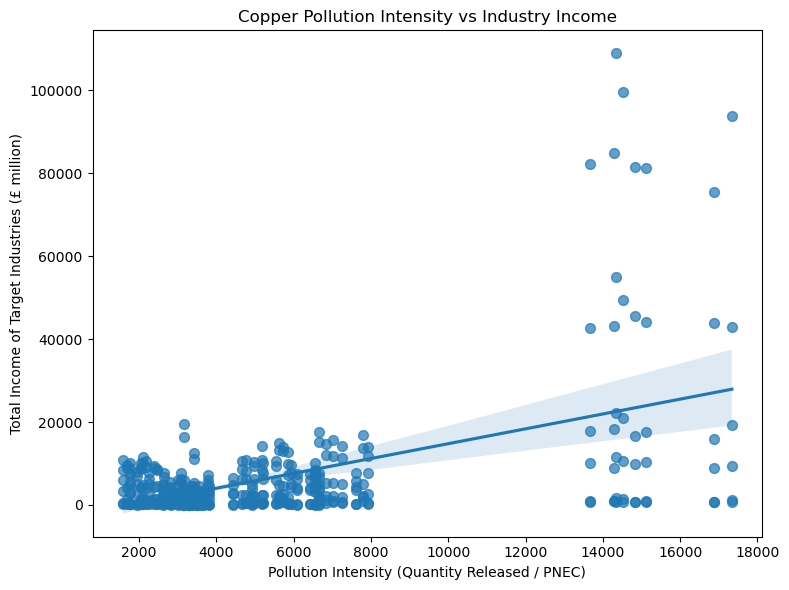

In [121]:
if len(merged_df) >= 2:
    # The merged data points are insufficient to calculate the correlation
    r, p = pearsonr(merged_df["Pollution Intensity"], merged_df["Indu_Income"])
    print(f'Pearson correlation coefficient r = {r:.4f}')
    print(f'p-value = {p:.4f}')

    # Determine significance
    alpha = 0.05
    if p < alpha:
        print(f"The result was significant (p < {alpha}), the null hypothesis was rejected, and there was a correlation between the two.")
    else:
        print(f"The result was not significant (p >= {alpha}), and the null hypothesis could not be rejected. There was no significant correlation between the two.")

    # visualization
    plt.figure(figsize=(8,6))
    sns.regplot(x="Pollution Intensity", y="Indu_Income", data=merged_df, scatter_kws={"s":50, "alpha":0.7})
    plt.title("Copper Pollution Intensity vs Industry Income")
    plt.xlabel("Pollution Intensity (Quantity Released / PNEC)")
    plt.ylabel("Total Income of Target Industries (£ million)")
    plt.tight_layout()
    plt.show()
else:
    print("The merged data points are insufficient to calculate the correlation and plot")


### Regression

                            OLS Regression Results                            
Dep. Variable:            Indu_Income   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     133.4
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           1.13e-26
Time:                        22:01:52   Log-Likelihood:                -4156.6
No. Observations:                 384   AIC:                             8317.
Df Residuals:                     382   BIC:                             8325.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3125.3936   1

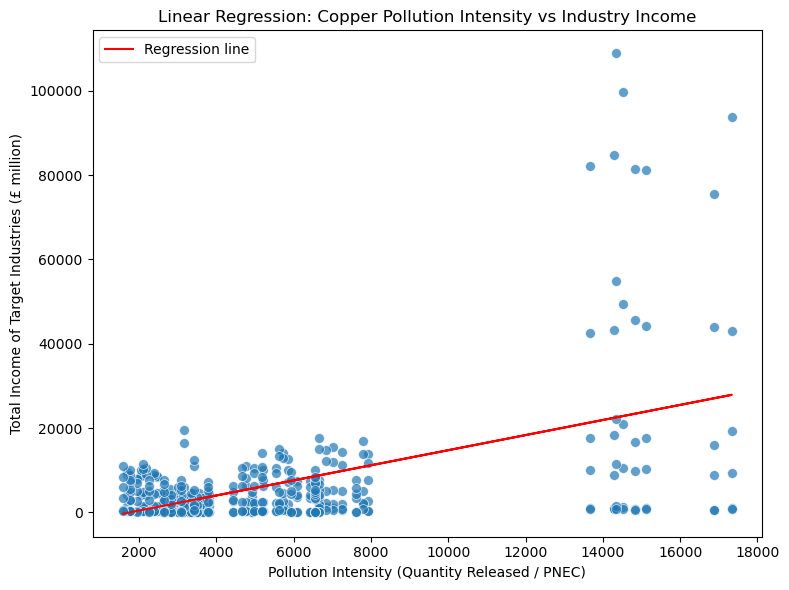

In [119]:
if len(merged_df) >= 2:
    X = merged_df["Pollution Intensity"]
    y = merged_df["Indu_Income"]

    # constant term (intercept)
    X_const = sm.add_constant(X)

    # fit the linear model
    model = sm.OLS(y, X_const).fit()

    #  summary of the regression results
    print(model.summary())
    
    # coeff
    intercept = model.params["const"]
    slope = model.params["Pollution Intensity"]

    # Print the regression equation
    print(f"\n Regression equation：")
    print(f"Indu_Income = {intercept:.4f} + {slope:.4f} * Pollution_Intensity")
    
    # Draw the scatter plot and the regression line
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="Pollution Intensity", y="Indu_Income", data=merged_df, s=50, alpha=0.7)
    
    # Draw the regression line using the values predicted by the model
    plt.plot(X, model.predict(X_const), color='red', label='Regression line')
    plt.xlabel("Pollution Intensity (Quantity Released / PNEC)")
    plt.ylabel("Total Income of Target Industries (£ million)")
    plt.title("Linear Regression: Copper Pollution Intensity vs Industry Income")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("The data points are insufficient to conduct regression analysis")


### Relationship between regional pollution and regional industry income

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


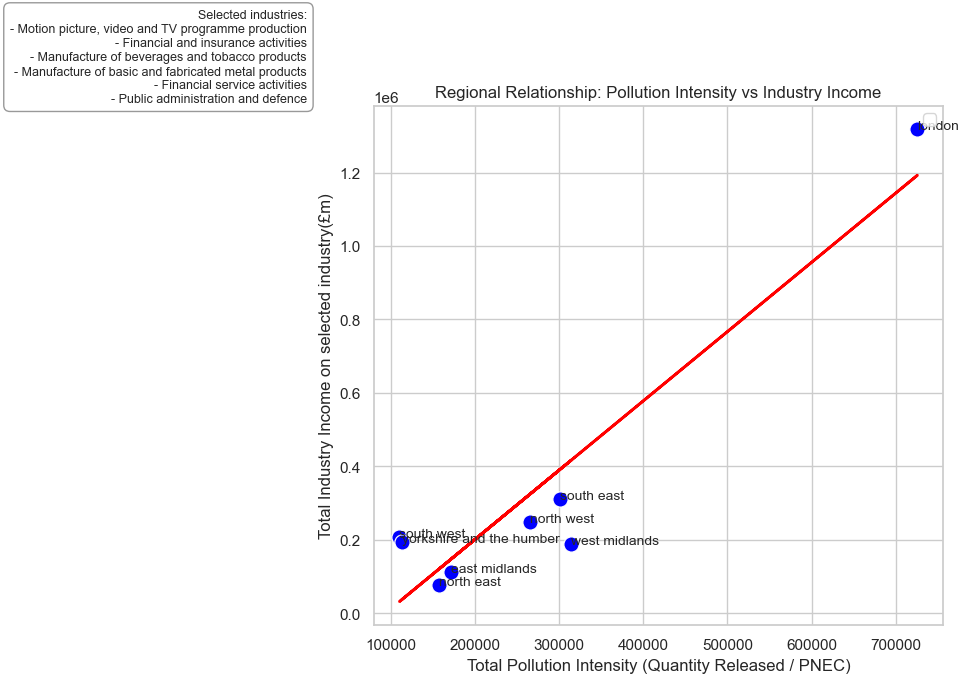

                            OLS Regression Results                            
Dep. Variable:            Indu_Income   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     43.73
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           0.000576
Time:                        22:24:04   Log-Likelihood:                -105.64
No. Observations:                   8   AIC:                             215.3
Df Residuals:                       6   BIC:                             215.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.758e+05   9

/Users/macbookair/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [138]:
# Aggregate by REGION
region_summary = merged_df.groupby("REGION").agg({
    "Pollution Intensity": "sum",
    "Indu_Income": "sum"
}).reset_index()

# Regression
X = region_summary["Pollution Intensity"]
y = region_summary["Indu_Income"]
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Extract regression parameters
intercept = model.params["const"]
slope = model.params["Pollution Intensity"]
r_squared = model.rsquared
p_value = model.pvalues["Pollution Intensity"]

# visualization
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# scatter plot
sns.scatterplot(
    data=region_summary,
    x="Pollution Intensity",
    y="Indu_Income",
    s=120,
    color="blue"
)

# Note: Region name
for i, row in region_summary.iterrows():
    plt.text(row["Pollution Intensity"] + 0.01, row["Indu_Income"], row["REGION"], fontsize=10)

x_vals = X
y_pred = model.predict(X_const)
plt.plot(x_vals, y_pred, color='red', linewidth=2)

# Annotate the regression equation, R² and P value
eq_text = f"y = {intercept:.2f} + {slope:.2f}x"
r2_text = f"R² = {r_squared:.3f}"
pval_text = f"P = {p_value:.4f}"
sig_text = "Significant" if p_value < 0.05 else "Not Significant"

# note the selected industries
industry_text = "Selected industries:\n" + "\n".join(["- " + s for s in target_industries])

plt.text(
    x=0.95,
    y=region_summary["Indu_Income"].max()*1.05,
    s=industry_text,
    ha='right',
    va='bottom',
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
)

plt.xlabel("Total Pollution Intensity (Quantity Released / PNEC)")
plt.ylabel("Total Industry Income on selected industry(£m)")
plt.title("Regional Relationship: Pollution Intensity vs Industry Income")
plt.legend()
plt.tight_layout()
plt.show()

print(model.summary())
